# Sea Animals Image Classification Project

https://www.kaggle.com/datasets/markdaniellampa/fish-dataset


https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste


https://www.kaggle.com/datasets/giannisgeorgiou/fish-species

### Member
 - 6310401009 ณัฐภัทร สุดประเสริฐ
 - 6310401165 วิศรุต หอมแก่นจันทร์

# Import

In [23]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import random
import pickle

# Model
from keras import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

# Data path and classes

In [2]:
data = "sea-animal-image"
classes = sorted(os.listdir(data))
classes

['basking',
 'blacktip',
 'blue',
 'bull',
 'hammerhead',
 'lemon',
 'mako',
 'nurse',
 'sand tiger',
 'thresher',
 'tiger',
 'whale',
 'white',
 'whitetip']

# Classes Info

In [3]:
classes_info = {}
for name in classes:
    classes_info[name] = len(os.listdir(data + f'/{name}'))
print(classes_info)

{'basking': 151, 'blacktip': 170, 'blue': 138, 'bull': 126, 'hammerhead': 140, 'lemon': 140, 'mako': 127, 'nurse': 101, 'sand tiger': 105, 'thresher': 132, 'tiger': 106, 'whale': 153, 'white': 135, 'whitetip': 138}


In [4]:
fig = px.bar(x=classes_info.keys(),y=classes_info.values(),title='Classes Info ')
fig.show()

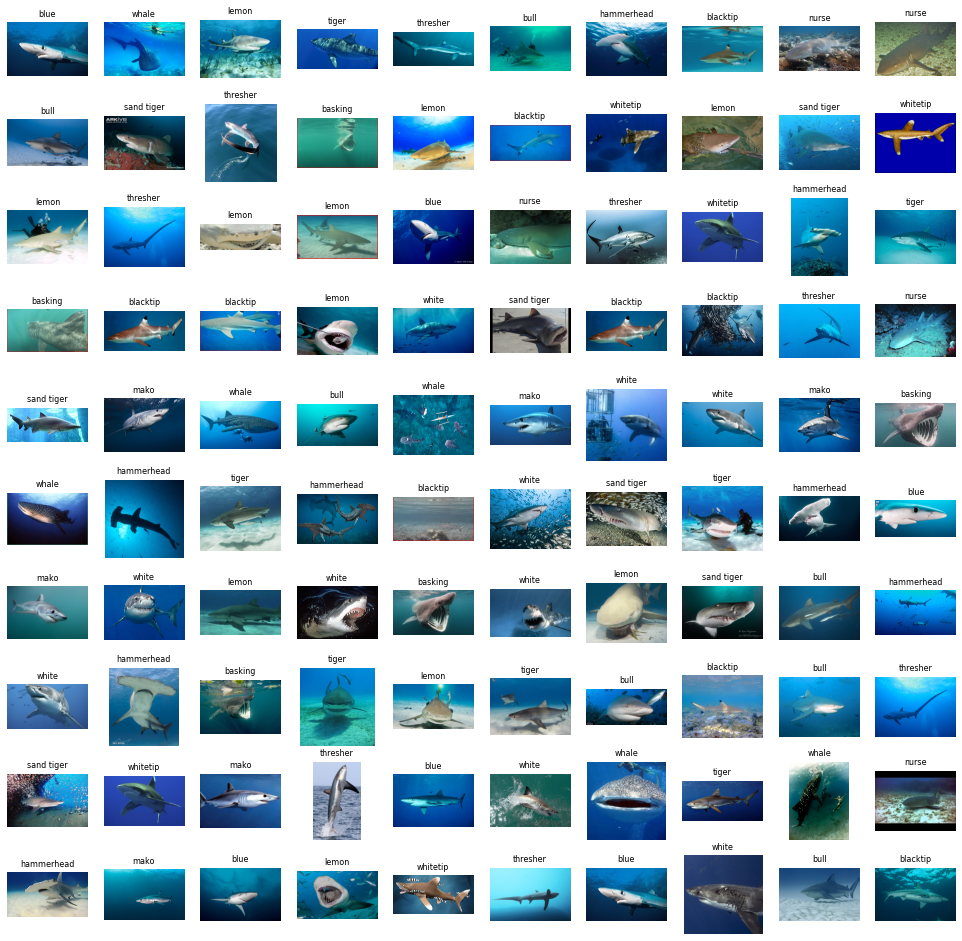

In [6]:
# visualize the training data
W = 10
H = 10
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array

# Select a random number from 0 to n_training/ images will be selected randomly
for i in np.arange(0, W * H): 
    
    # Select a class randomly
    label = random.choice(os.listdir(data))
    class_dir = os.path.join(data,label)
    
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

# Data Splitting

In [7]:
train_val_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    zoom_range = 0.2,
    validation_split = 0.1
)

test_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# datasets

training_set = train_val_gen.flow_from_directory(
    data,
    target_size=(200,200),
    batch_size=32,
    shuffle = True,
    class_mode= 'categorical',
    subset = 'training',
    seed=42
)

validation_set = train_val_gen.flow_from_directory(
    data,
    target_size=(200,200),
    batch_size=32,
    shuffle = True,
    class_mode= 'categorical',
    subset = 'validation',
    seed=42
)

test_set = test_gen.flow_from_directory(
    data,
    target_size=(200,200),
    batch_size=32,
    shuffle = True,
    class_mode= 'categorical',
    subset = 'validation',
    seed=42
)

Found 1671 images belonging to 14 classes.
Found 180 images belonging to 14 classes.
Found 367 images belonging to 14 classes.


In [8]:
training_set.class_indices

{'basking': 0,
 'blacktip': 1,
 'blue': 2,
 'bull': 3,
 'hammerhead': 4,
 'lemon': 5,
 'mako': 6,
 'nurse': 7,
 'sand tiger': 8,
 'thresher': 9,
 'tiger': 10,
 'whale': 11,
 'white': 12,
 'whitetip': 13}

In [9]:
training_set[0][0].shape

(32, 200, 200, 3)

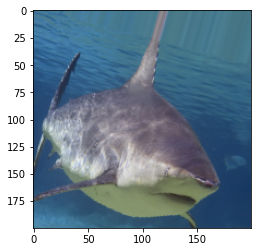

In [10]:
plt.imshow(training_set[0][0][0])

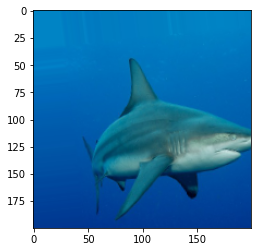

In [11]:
plt.imshow(validation_set[0][0][0])

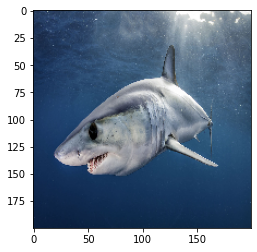

In [12]:
plt.imshow(test_set[0][0][0])

## Defined function to show the performance

In [32]:
def plot_acc_and_loss(history):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Accuracy", "Loss"))
    
    quantity = [i for i in range(1, len(history.history["accuracy"])+1)]
    
    fig.add_trace(go.Scatter(x=quantity, y=history.history["accuracy"], name="accuracy", line=dict(color='royalblue')),
              row=1, col=1)

    fig.add_trace(go.Scatter(x=quantity, y=history.history["val_accuracy"], name="val_accuracy", line=dict(color='firebrick')),
              row=1, col=1)
    
    fig.add_trace(go.Scatter(x=quantity, y=history.history["loss"], name="loss", line=dict(color='royalblue')),
              row=1, col=2)

    fig.add_trace(go.Scatter(x=quantity, y=history.history["val_loss"], name="val_loss", line=dict(color='firebrick')),
              row=1, col=2)
    
    fig.show()

## VGG16

In [19]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
vgg.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [20]:
inputs = Input(shape=(200, 200, 3))
inputs = tf.cast(inputs, tf.float32)
#top_model = tf.keras.applications.vgg16.preprocess_input(inputs)    #problem -cut it-
top_model = inputs

for layer in vgg.layers[1:19]:
    top_model = layer(top_model)

top_model = Flatten()(top_model)
top_model = Dense(64, activation='relu')(top_model)
top_model = Dense(64, activation='relu')(top_model)
outputs = Dense(14, activation='softmax')(top_model)
vgg16_model = Model(inputs=inputs, outputs=outputs)
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [21]:
#checkpoint = ModelCheckpoint("model_v1.weights.best.hdf5", 
#                             verbose=1, 
#                             save_best_only=True)

vgg16_model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [22]:
vgg16_hist = vgg16_model.fit(training_set,  
                 epochs=50, 
                 validation_data=validation_set,
                 verbose=1)

Epoch 1/50
53/53 [==============================] - 360s 7s/step - loss: 2.5760 - accuracy: 0.1329 - val_loss: 2.2156 - val_accuracy: 0.2833
Epoch 2/50
53/53 [==============================] - 348s 7s/step - loss: 2.1444 - accuracy: 0.3016 - val_loss: 1.8486 - val_accuracy: 0.4111
Epoch 3/50
53/53 [==============================] - 361s 7s/step - loss: 1.8706 - accuracy: 0.3794 - val_loss: 1.7563 - val_accuracy: 0.4500
Epoch 4/50
53/53 [==============================] - 359s 7s/step - loss: 1.7396 - accuracy: 0.4171 - val_loss: 1.5986 - val_accuracy: 0.4444
Epoch 5/50
53/53 [==============================] - 347s 7s/step - loss: 1.5375 - accuracy: 0.5033 - val_loss: 1.4375 - val_accuracy: 0.5278
Epoch 6/50
53/53 [==============================] - 369s 7s/step - loss: 1.5248 - accuracy: 0.4877 - val_loss: 1.4464 - val_accuracy: 0.5222
Epoch 7/50
53/53 [==============================] - 366s 7s/step - loss: 1.4206 - accuracy: 0.5290 - val_loss: 1.3424 - val_accuracy: 0.5722
Epoch 8/50
53

### Show accuracy and loss graph

In [33]:
plot_acc_and_loss(vgg16_hist)

### Save model

In [34]:
filename = 'vgg16_model.sav'
pickle.dump(vgg16_model, open('prototype_model/{}'.format(filename), 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_10
......vars
.........0
.........1
...layers\conv2d_11
......vars
.........0
.........1
...layers\conv2d_12
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\conv2d_6
......vars
.........0
.........1
...layers\conv2d_7
......vars
.........0
.........1
...layers\conv2d_8
......vars
.........0
.........1
...layers\conv2d_9
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\flatten
......vars
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers

### Test performance

In [35]:
filename = 'vgg16_model.sav'
loaded_model = pickle.load(open('prototype_model/{}'.format(filename), 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-08 04:56:46        11980
metadata.json                                  2023-03-08 04:56:46           64
variables.h5                                   2023-03-08 04:56:48     73147784
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_10
......vars
.........0
.........1
...layers\conv2d_11
......vars
.........0
.........1
...layers\conv2d_12
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\conv2d_6
......vars
.........0
.........1
...layers\conv2d_7
......vars
.........0
.........1
...layers\co